# Di Tella 2017
This file replicates the results from [Di Tella 2017, Uncertainty Shocks and Balance Sheet Recessions](https://gsb-faculty.stanford.edu/sebastian-di-tella/files/2022/10/DiTella_Unc_Shocks_2556027.pdf)

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModelTimeStep
from deep_macrofin import ActivationType, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    # variables
    r"\iota": "iota",
    r"\hat{e}": "e_hat",
    r"\hat{c}": "c_hat",
    r"\sigma_{x,1}": "sigxtop",
    r"\sigma_{x,2}": "sigxbot",
    r"\sigma_x": "sigx",
    r"\sigma_p": "sigp",
    r"\sigma_\xi": "sigxi",
    r"\sigma_\zeta": "sigzeta",
    r"\tilde{\sigma_n}": "signtilde",
    r"\sigma_n": "sign",
    r"\pi": "signxi",
    r"\sigma_w": "sigw",
    r"\mu_n": "mun",
    r"\mu_x": "mux",
    r"\mu_p": "mup",
    r"\mu_\xi": "muxi",
    r"\mu_\zeta": "muzeta",
    r"\mu_w": "muw",

    # agents
    r"\xi": "xi",
    r"\zeta": "zeta",

    # constants
    r"\bar{\sigma_v}": "sigv_mean",
    r"\sigma_v": "sigv",
    r"\mu_v": "muv",
    r"\sigma": "sigma",
    r"\lambda": "lbd",
    r"\bar{v}": "v_mean",
    r"\rho": "rho",
    r"\gamma": "gamma",
    r"\psi": "psi",
    r"\tau": "tau",
    r"\delta": "delta",
    r"\phi": "phi",
}

In [3]:
set_seeds(0)
pde_model = PDEModelTimeStep("ditella", 
                     {"batch_size": 20, "num_outer_iterations": 50, "num_inner_iterations": 5000}, 
                     latex_var_mapping)
pde_model.set_state(["x", "v"], {"x": [0.05, 0.95], "v": [0.05, 0.95]})
pde_model.add_agents(["xi", "zeta"], 
                     {"xi": {
                         "positive": True, 
                        }, 
                      "zeta": {
                          "positive": True, 
                          }
                     })
pde_model.add_endogs(["p", "r"], 
                     {"p": {
                         "positive": True, 
                         },
                     })
# pde_model.set_initial_guess({"p": 7.0})
pde_model.add_params({
    "a": 1,
    "sigma": 0.0125,
    "lbd": 1.38,
    "v_mean": 0.25,
    "sigv_mean": -0.17,
    "rho": 0.0665,
    "gamma": 5,
    "psi": 0.5,
    "tau": 1.15,
    "phi": 0.2,

    "A": 53.2,
    "B": -0.8668571428571438,
    "delta": 0.05,
})
pde_model.add_equation(r"$g &= \frac{1}{2*A} * (p - B) - \delta$") # g &= \frac{1}{2*A} * (p - B) - \delta
pde_model.add_equation(r"$\iota &= A * (g+\delta)^2 + B * (g+\delta)$") # \iota &= A * (g+\delta)^2 + B * (g+\delta)
pde_model.add_equation(r"$\mu_v &= \lambda * (\bar{v} - v)$")
pde_model.add_equation(r"$\sigma_v &= \bar{\sigma_v} * \sqrt{v}$")
pde_model.add_equation(r"$\hat{e} &= \rho^{1/\psi} * \xi^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\hat{c} &= \rho^{1/\psi} * \zeta^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\sigma_{x,1} &= (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial v} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial v} \right)$")
pde_model.add_equation(r"$\sigma_{x,2} &= 1 - (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial x} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial x} \right)$")
pde_model.add_equation(r"$\sigma_x &= \frac{\sigma_{x,1}}{\sigma_{x,2}} * \sigma_v$")
pde_model.add_equation(r"$\sigma_p &= \frac{1}{p} * \left( \frac{\partial p}{\partial v} * \sigma_v + \frac{\partial p}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\xi &= \frac{1}{\xi} * \left( \frac{\partial \xi}{\partial v} * \sigma_v + \frac{\partial \xi}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\zeta &= \frac{1}{\zeta} * \left( \frac{\partial \zeta}{\partial v} * \sigma_v + \frac{\partial \zeta}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_n &= \sigma + \sigma_p + \frac{\sigma_x}{x}$")
pde_model.add_equation(r"$\pi &= \gamma * \sigma_n + (\gamma-1) * \sigma_\xi$")
pde_model.add_equation(r"$\sigma_w &= \frac{\pi}{\gamma} - \frac{\gamma-1}{\gamma} *  \sigma_\zeta$")
pde_model.add_equation(r"$\mu_w &= r + \pi * \sigma_w$")
pde_model.add_equation(r"$\mu_n &= r + \frac{\gamma}{x^2} * (\phi * v)^2 + \pi * \sigma_n$")
pde_model.add_equation(r"$\tilde{\sigma_n} &= \frac{\phi}{x} * v$")
pde_model.add_equation(r"$\mu_x &= x * \left(\mu_n - \hat{e} - \tau + \frac{a-\iota}{p} - r - \pi * (\sigma+\sigma_p) - \frac{\gamma}{x} * (\phi * v)^2 + (\sigma + \sigma_p)^2 - \sigma_n * (\sigma + \sigma_p)\right)$")
pde_model.add_equation(r"$\mu_p &= \frac{1}{p} * \left( \frac{\partial p}{\partial t} + \mu_v * \frac{\partial p}{\partial v} + \mu_x * \frac{\partial p}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 p}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 p}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 p}{\partial x^2} \right)\right)$")
pde_model.add_equation(r"$\mu_\xi &= \frac{1}{\xi} * \left( \frac{\partial \xi}{\partial t} + \mu_v * \frac{\partial \xi}{\partial v} + \mu_x * \frac{\partial \xi}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \xi}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \xi}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \xi}{\partial x^2} \right)\right)$")
pde_model.add_equation(r"$\mu_\zeta &= \frac{1}{\zeta} * \left( \frac{\partial \zeta}{\partial t} + \mu_v * \frac{\partial \zeta}{\partial v} + \mu_x * \frac{\partial \zeta}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \zeta}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \zeta}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \zeta}{\partial x^2} \right)\right)$")

pde_model.add_endog_equation(r"$a - \iota &= p * (\hat{e} * x + \hat{c} * (1-x))$")
pde_model.add_endog_equation(r"$\sigma + \sigma_p &= \sigma_n * x + \sigma_w * (1-x)$")
pde_model.add_endog_equation(r"$\frac{a-\iota}{p} + g + \mu_p + \sigma * \sigma_p - r &= (\sigma + \sigma_p) * \pi + \gamma * \frac{1}{x} * (\phi * v)^2$")

pde_model.add_hjb_equation(r"$\frac{\hat{e}^{1-\psi}}{1-\psi} * \rho * \xi^{\psi-1} + \frac{\tau}{1-\gamma} * \left(\left(\frac{\zeta}{\xi} \right)^{1-\gamma}-1 \right) + \mu_n - \hat{e} + \mu_\xi - \frac{\gamma}{2} * \left( \sigma_n^2 + \sigma_\xi^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_n * \sigma_\xi + \tilde{\sigma_n}^2 \right) - \frac{\rho}{1-\psi}$")
pde_model.add_hjb_equation(r"$\frac{\hat{c}^{1-\psi}}{1-\psi} * \rho * \zeta^{\psi-1} + \mu_w - \hat{c} + \mu_\zeta - \frac{\gamma}{2} * \left( \sigma_w^2 + \sigma_\zeta^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_w * \sigma_\zeta \right) - \frac{\rho}{1-\psi}$")
print(pde_model)
if not os.path.exists("./models/ditella/model.pt"):
    pde_model.train_model("./models/ditella", "model.pt", True)
    pde_model.load_model(torch.load("./models/ditella/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/ditella/model_best.pt"))
    pde_model.eval_model(True)

============================Summary of Model ditella============================
Config: {
 "batch_size": 20,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001
}
Latex Variable Mapping:
{
 "\\iota": "iota",
 "\\hat{e}": "e_hat",
 "\\hat{c}": "c_hat",
 "\\sigma_{x,1}": "sigxtop",
 "\\sigma_{x,2}": "sigxbot",
 "\\sigma_x": "sigx",
 "\\sigma_p": "sigp",
 "\\sigma_\\xi": "sigxi",
 "\\sigma_\\zeta": "sigzeta",
 "\\tilde{\\sigma_n}": "signtilde",
 "\\sigma_n": "sign",
 "\\pi": "signxi",
 "\\sigma_w": "sigw",
 "\\mu_n": "mun",
 "\\mu_x": "mux",
 "\\mu_p": "mup",
 "\\mu_\\xi": "muxi",
 "\\mu_\\zeta": "muzeta",
 "\\mu_w": "muw",
 "\\xi": "xi",
 "\\zeta": "zeta",
 "\\bar{\\sigma_v}": "sigv_mean",
 "\\sigma_v": "sigv",
 "\\mu_v": "muv",
 "\\sigma": "sigma",
 "\\lambda": "lbd",
 "\\bar{v}": "v_mean",
 "\\rho": "rho",
 "\\gamma": "gamma",
 "\\psi": "psi

Total loss: 0.9228: 100%|██████████| 5000/5000 [10:20<00:00,  8.06it/s]
D:\Research\continuous-time-eco-models\deep_macrofin\pde_model_time_step.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Model loaded
xi: Mean Value: 0.15005 Absolute Change: 0.84995, Relative Change:  0.84995
zeta: Mean Value: 0.13290 Absolute Change: 0.86710, Relative Change:  0.86710
p: Mean Value: 9.94746 Absolute Change: 8.94746, Relative Change:  8.94746
r: Mean Value: -0.33711 Absolute Change: 1.33711, Relative Change:  1.33711
Updating min loss from inf to 0.6383
Outer Loop 0 Finished in 620.5221s. Loading best model...


Total loss: 0.0109: 100%|██████████| 3535/3535 [07:17<00:00,  8.09it/s]


Model loaded
xi: Mean Value: 0.10794 Absolute Change: 0.04211, Relative Change:  0.27579
zeta: Mean Value: 0.09065 Absolute Change: 0.04225, Relative Change:  0.31754
p: Mean Value: 10.51882 Absolute Change: 0.57136, Relative Change:  0.05709
r: Mean Value: 0.00325 Absolute Change: 0.34036, Relative Change:  1.06728
Updating min loss from 0.6383 to 0.0082
Outer Loop 1 Finished in 437.0583s. Loading best model...


Total loss: 0.0019: 100%|██████████| 2886/2886 [06:14<00:00,  7.71it/s]


Model loaded
xi: Mean Value: 0.09796 Absolute Change: 0.00998, Relative Change:  0.08880
zeta: Mean Value: 0.08210 Absolute Change: 0.00855, Relative Change:  0.09546
p: Mean Value: 10.04650 Absolute Change: 0.47232, Relative Change:  0.04424
r: Mean Value: 0.02969 Absolute Change: 0.04656, Relative Change:  2.43098
Updating min loss from 0.0082 to 0.0019
Outer Loop 2 Finished in 374.3642s. Loading best model...


Total loss: 0.0011: 100%|██████████| 2500/2500 [05:19<00:00,  7.84it/s]


Model loaded
xi: Mean Value: 0.08899 Absolute Change: 0.00898, Relative Change:  0.09190
zeta: Mean Value: 0.07497 Absolute Change: 0.00713, Relative Change:  0.08705
p: Mean Value: 9.76223 Absolute Change: 0.28427, Relative Change:  0.02826
r: Mean Value: 0.01286 Absolute Change: 0.01766, Relative Change:  2.61684
Updating min loss from 0.0019 to 0.0011
Outer Loop 3 Finished in 319.0459s. Loading best model...


Total loss: 0.0007: 100%|██████████| 2236/2236 [04:45<00:00,  7.84it/s]


Model loaded
xi: Mean Value: 0.08368 Absolute Change: 0.00530, Relative Change:  0.05969
zeta: Mean Value: 0.07064 Absolute Change: 0.00433, Relative Change:  0.05799
p: Mean Value: 9.53105 Absolute Change: 0.23118, Relative Change:  0.02370
r: Mean Value: 0.00758 Absolute Change: 0.00603, Relative Change:  0.30400
Updating min loss from 0.0011 to 0.0007
Outer Loop 4 Finished in 285.2493s. Loading best model...


Total loss: 0.0006: 100%|██████████| 2041/2041 [04:17<00:00,  7.93it/s]


Model loaded
xi: Mean Value: 0.07948 Absolute Change: 0.00420, Relative Change:  0.05018
zeta: Mean Value: 0.06721 Absolute Change: 0.00342, Relative Change:  0.04867
p: Mean Value: 9.33265 Absolute Change: 0.19840, Relative Change:  0.02083
r: Mean Value: 0.00215 Absolute Change: 0.00685, Relative Change:  0.28367
Updating min loss from 0.0007 to 0.0005
Outer Loop 5 Finished in 257.4255s. Loading best model...


Total loss: 0.0004: 100%|██████████| 1889/1889 [04:05<00:00,  7.70it/s]


Model loaded
xi: Mean Value: 0.07566 Absolute Change: 0.00382, Relative Change:  0.04799
zeta: Mean Value: 0.06402 Absolute Change: 0.00319, Relative Change:  0.04747
p: Mean Value: 9.14250 Absolute Change: 0.19015, Relative Change:  0.02039
r: Mean Value: -0.00072 Absolute Change: 0.00328, Relative Change:  0.09476
Updating min loss from 0.0005 to 0.0004
Outer Loop 6 Finished in 245.2318s. Loading best model...


Total loss: 0.0004: 100%|██████████| 1767/1767 [03:56<00:00,  7.48it/s]


Model loaded
xi: Mean Value: 0.07223 Absolute Change: 0.00342, Relative Change:  0.04520
zeta: Mean Value: 0.06120 Absolute Change: 0.00282, Relative Change:  0.04407
p: Mean Value: 8.96136 Absolute Change: 0.18114, Relative Change:  0.01983
r: Mean Value: -0.00225 Absolute Change: 0.00160, Relative Change:  0.06074
Updating min loss from 0.0004 to 0.0003
Outer Loop 7 Finished in 236.2462s. Loading best model...


Total loss: 0.0008: 100%|██████████| 1666/1666 [03:35<00:00,  7.75it/s]


Model loaded
xi: Mean Value: 0.06932 Absolute Change: 0.00291, Relative Change:  0.04029
zeta: Mean Value: 0.05876 Absolute Change: 0.00244, Relative Change:  0.03977
p: Mean Value: 8.79524 Absolute Change: 0.16612, Relative Change:  0.01855
r: Mean Value: -0.00529 Absolute Change: 0.00329, Relative Change:  0.08782
Updating min loss from 0.0003 to 0.0003
Outer Loop 8 Finished in 215.0624s. Loading best model...


Total loss: 0.0003: 100%|██████████| 1581/1581 [03:25<00:00,  7.68it/s]


Model loaded
xi: Mean Value: 0.06665 Absolute Change: 0.00268, Relative Change:  0.03862
zeta: Mean Value: 0.05658 Absolute Change: 0.00218, Relative Change:  0.03701
p: Mean Value: 8.63974 Absolute Change: 0.15549, Relative Change:  0.01769
r: Mean Value: -0.00679 Absolute Change: 0.00152, Relative Change:  0.37062
Updating min loss from 0.0003 to 0.0003
Outer Loop 9 Finished in 205.8033s. Loading best model...


Total loss: 0.0004: 100%|██████████| 1507/1507 [03:13<00:00,  7.78it/s]


Model loaded
xi: Mean Value: 0.06427 Absolute Change: 0.00238, Relative Change:  0.03563
zeta: Mean Value: 0.05446 Absolute Change: 0.00212, Relative Change:  0.03733
p: Mean Value: 8.48727 Absolute Change: 0.15248, Relative Change:  0.01767
r: Mean Value: -0.00796 Absolute Change: 0.00122, Relative Change:  0.02602
Updating min loss from 0.0003 to 0.0002
Outer Loop 10 Finished in 193.6986s. Loading best model...


Total loss: 0.0002: 100%|██████████| 1443/1443 [03:02<00:00,  7.90it/s]


Model loaded
xi: Mean Value: 0.06217 Absolute Change: 0.00210, Relative Change:  0.03267
zeta: Mean Value: 0.05281 Absolute Change: 0.00165, Relative Change:  0.03035
p: Mean Value: 8.35492 Absolute Change: 0.13235, Relative Change:  0.01560
r: Mean Value: -0.00940 Absolute Change: 0.00182, Relative Change:  0.06601
Updating min loss from 0.0002 to 0.0002
Outer Loop 11 Finished in 182.5686s. Loading best model...


Total loss: 0.0012: 100%|██████████| 1386/1386 [02:50<00:00,  8.15it/s]


Model loaded
xi: Mean Value: 0.06030 Absolute Change: 0.00187, Relative Change:  0.03012
zeta: Mean Value: 0.05113 Absolute Change: 0.00168, Relative Change:  0.03168
p: Mean Value: 8.22275 Absolute Change: 0.13218, Relative Change:  0.01584
r: Mean Value: -0.01018 Absolute Change: 0.00082, Relative Change:  0.01694
Updating min loss from 0.0002 to 0.0002
Outer Loop 12 Finished in 170.0754s. Loading best model...


Total loss: 0.0003: 100%|██████████| 1336/1336 [02:55<00:00,  7.62it/s]


Model loaded
xi: Mean Value: 0.05858 Absolute Change: 0.00172, Relative Change:  0.02851
zeta: Mean Value: 0.04968 Absolute Change: 0.00145, Relative Change:  0.02835
p: Mean Value: 8.10197 Absolute Change: 0.12078, Relative Change:  0.01470
r: Mean Value: -0.01184 Absolute Change: 0.00166, Relative Change:  0.05023
Updating min loss from 0.0002 to 0.0002
Outer Loop 13 Finished in 175.3807s. Loading best model...


Total loss: 0.0002: 100%|██████████| 1290/1290 [02:54<00:00,  7.41it/s]


Model loaded
xi: Mean Value: 0.05705 Absolute Change: 0.00154, Relative Change:  0.02625
zeta: Mean Value: 0.04839 Absolute Change: 0.00129, Relative Change:  0.02601
p: Mean Value: 7.98967 Absolute Change: 0.11230, Relative Change:  0.01387
r: Mean Value: -0.01334 Absolute Change: 0.00150, Relative Change:  0.75045
Updating min loss from 0.0002 to 0.0002
Outer Loop 14 Finished in 174.0172s. Loading best model...


Total loss: 0.0002: 100%|██████████| 1250/1250 [02:34<00:00,  8.07it/s]


Model loaded
xi: Mean Value: 0.05572 Absolute Change: 0.00133, Relative Change:  0.02332
zeta: Mean Value: 0.04739 Absolute Change: 0.00099, Relative Change:  0.02052
p: Mean Value: 7.89597 Absolute Change: 0.09370, Relative Change:  0.01173
r: Mean Value: -0.01443 Absolute Change: 0.00174, Relative Change:  0.11794
Outer Loop 15 Finished in 154.9818s. Loading best model...


Total loss: 0.0002: 100%|██████████| 1212/1212 [02:38<00:00,  7.66it/s]


Model loaded
xi: Mean Value: 0.05455 Absolute Change: 0.00117, Relative Change:  0.02104
zeta: Mean Value: 0.04630 Absolute Change: 0.00109, Relative Change:  0.02295
p: Mean Value: 7.79904 Absolute Change: 0.09693, Relative Change:  0.01229
r: Mean Value: -0.01466 Absolute Change: 0.00069, Relative Change:  0.02376
Updating min loss from 0.0002 to 0.0002
Outer Loop 16 Finished in 158.1349s. Loading best model...


Total loss: 0.0002: 100%|██████████| 1178/1178 [02:38<00:00,  7.45it/s]


Model loaded
xi: Mean Value: 0.05343 Absolute Change: 0.00112, Relative Change:  0.02045
zeta: Mean Value: 0.04538 Absolute Change: 0.00092, Relative Change:  0.01992
p: Mean Value: 7.71211 Absolute Change: 0.08693, Relative Change:  0.01115
r: Mean Value: -0.01605 Absolute Change: 0.00139, Relative Change:  0.41769
Updating min loss from 0.0002 to 0.0002
Outer Loop 17 Finished in 158.2239s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1147/1147 [02:23<00:00,  8.01it/s]


Model loaded
xi: Mean Value: 0.05243 Absolute Change: 0.00100, Relative Change:  0.01879
zeta: Mean Value: 0.04450 Absolute Change: 0.00088, Relative Change:  0.01928
p: Mean Value: 7.63002 Absolute Change: 0.08209, Relative Change:  0.01065
r: Mean Value: -0.01775 Absolute Change: 0.00171, Relative Change:  1.64266
Updating min loss from 0.0002 to 0.0001
Outer Loop 18 Finished in 143.2194s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1118/1118 [02:30<00:00,  7.44it/s]


Model loaded
xi: Mean Value: 0.05152 Absolute Change: 0.00091, Relative Change:  0.01745
zeta: Mean Value: 0.04373 Absolute Change: 0.00077, Relative Change:  0.01725
p: Mean Value: 7.55542 Absolute Change: 0.07460, Relative Change:  0.00978
r: Mean Value: -0.01919 Absolute Change: 0.00143, Relative Change:  0.17276
Updating min loss from 0.0001 to 0.0001
Outer Loop 19 Finished in 150.3635s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1091/1091 [02:19<00:00,  7.83it/s]


Model loaded
xi: Mean Value: 0.05070 Absolute Change: 0.00082, Relative Change:  0.01589
zeta: Mean Value: 0.04308 Absolute Change: 0.00065, Relative Change:  0.01493
p: Mean Value: 7.48772 Absolute Change: 0.06770, Relative Change:  0.00896
r: Mean Value: -0.02019 Absolute Change: 0.00103, Relative Change:  0.26865
Updating min loss from 0.0001 to 0.0001
Outer Loop 20 Finished in 139.3577s. Loading best model...


Total loss: 0.0003: 100%|██████████| 1066/1066 [02:15<00:00,  7.85it/s]


Model loaded
xi: Mean Value: 0.04996 Absolute Change: 0.00074, Relative Change:  0.01459
zeta: Mean Value: 0.04241 Absolute Change: 0.00067, Relative Change:  0.01543
p: Mean Value: 7.42290 Absolute Change: 0.06482, Relative Change:  0.00866
r: Mean Value: -0.02154 Absolute Change: 0.00135, Relative Change:  0.04480
Updating min loss from 0.0001 to 0.0001
Outer Loop 21 Finished in 135.8107s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1042/1042 [02:19<00:00,  7.45it/s]


Model loaded
xi: Mean Value: 0.04934 Absolute Change: 0.00062, Relative Change:  0.01248
zeta: Mean Value: 0.04203 Absolute Change: 0.00038, Relative Change:  0.00887
p: Mean Value: 7.37668 Absolute Change: 0.04622, Relative Change:  0.00622
r: Mean Value: -0.02196 Absolute Change: 0.00175, Relative Change:  0.10388
Outer Loop 22 Finished in 139.8100s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1020/1020 [02:01<00:00,  8.38it/s]


Model loaded
xi: Mean Value: 0.04884 Absolute Change: 0.00051, Relative Change:  0.01021
zeta: Mean Value: 0.04152 Absolute Change: 0.00052, Relative Change:  0.01230
p: Mean Value: 7.32640 Absolute Change: 0.05028, Relative Change:  0.00682
r: Mean Value: -0.02201 Absolute Change: 0.00083, Relative Change:  0.03869
Updating min loss from 0.0001 to 0.0001
Outer Loop 23 Finished in 121.6561s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1000/1000 [02:14<00:00,  7.41it/s]


Model loaded
xi: Mean Value: 0.04837 Absolute Change: 0.00047, Relative Change:  0.00966
zeta: Mean Value: 0.04126 Absolute Change: 0.00025, Relative Change:  0.00609
p: Mean Value: 7.29234 Absolute Change: 0.03407, Relative Change:  0.00464
r: Mean Value: -0.02243 Absolute Change: 0.00157, Relative Change:  0.17172
Outer Loop 24 Finished in 134.9301s. Loading best model...


Total loss: 0.0001: 100%|██████████| 980/980 [01:56<00:00,  8.39it/s]


Model loaded
xi: Mean Value: 0.04800 Absolute Change: 0.00037, Relative Change:  0.00759
zeta: Mean Value: 0.04089 Absolute Change: 0.00037, Relative Change:  0.00897
p: Mean Value: 7.25511 Absolute Change: 0.03723, Relative Change:  0.00511
r: Mean Value: -0.02248 Absolute Change: 0.00053, Relative Change:  0.07455
Updating min loss from 0.0001 to 0.0001
Outer Loop 25 Finished in 116.7421s. Loading best model...


Total loss: 0.0001: 100%|██████████| 962/962 [02:13<00:00,  7.21it/s]


Model loaded
xi: Mean Value: 0.04766 Absolute Change: 0.00034, Relative Change:  0.00721
zeta: Mean Value: 0.04066 Absolute Change: 0.00024, Relative Change:  0.00577
p: Mean Value: 7.22663 Absolute Change: 0.02848, Relative Change:  0.00391
r: Mean Value: -0.02306 Absolute Change: 0.00071, Relative Change:  0.05506
Updating min loss from 0.0001 to 0.0001
Outer Loop 26 Finished in 133.4517s. Loading best model...


Total loss: 0.0001: 100%|██████████| 944/944 [01:51<00:00,  8.43it/s]


Model loaded
xi: Mean Value: 0.04735 Absolute Change: 0.00030, Relative Change:  0.00631
zeta: Mean Value: 0.04032 Absolute Change: 0.00034, Relative Change:  0.00825
p: Mean Value: 7.19493 Absolute Change: 0.03170, Relative Change:  0.00439
r: Mean Value: -0.02363 Absolute Change: 0.00079, Relative Change:  0.02349
Updating min loss from 0.0001 to 0.0001
Outer Loop 27 Finished in 111.9529s. Loading best model...


Total loss: 0.0001: 100%|██████████| 928/928 [02:08<00:00,  7.22it/s]


Model loaded
xi: Mean Value: 0.04709 Absolute Change: 0.00026, Relative Change:  0.00562
zeta: Mean Value: 0.04027 Absolute Change: 0.00007, Relative Change:  0.00171
p: Mean Value: 7.17924 Absolute Change: 0.01569, Relative Change:  0.00216
r: Mean Value: -0.02413 Absolute Change: 0.00134, Relative Change:  0.07654
Outer Loop 28 Finished in 128.5089s. Loading best model...


Total loss: 0.0001: 100%|██████████| 912/912 [01:48<00:00,  8.40it/s]


Model loaded
xi: Mean Value: 0.04691 Absolute Change: 0.00019, Relative Change:  0.00387
zeta: Mean Value: 0.03998 Absolute Change: 0.00029, Relative Change:  0.00715
p: Mean Value: 7.15602 Absolute Change: 0.02322, Relative Change:  0.00325
r: Mean Value: -0.02429 Absolute Change: 0.00089, Relative Change:  0.03450
Updating min loss from 0.0001 to 0.0001
Outer Loop 29 Finished in 108.6376s. Loading best model...


Total loss: 0.0001: 100%|██████████| 898/898 [02:05<00:00,  7.16it/s]


Model loaded
xi: Mean Value: 0.04668 Absolute Change: 0.00023, Relative Change:  0.00493
zeta: Mean Value: 0.03982 Absolute Change: 0.00016, Relative Change:  0.00402
p: Mean Value: 7.13649 Absolute Change: 0.01953, Relative Change:  0.00272
r: Mean Value: -0.02512 Absolute Change: 0.00092, Relative Change:  0.05915
Updating min loss from 0.0001 to 0.0001
Outer Loop 30 Finished in 125.4855s. Loading best model...


Total loss: 0.0001: 100%|██████████| 883/883 [01:46<00:00,  8.33it/s]


Model loaded
xi: Mean Value: 0.04647 Absolute Change: 0.00021, Relative Change:  0.00449
zeta: Mean Value: 0.03955 Absolute Change: 0.00027, Relative Change:  0.00671
p: Mean Value: 7.11392 Absolute Change: 0.02257, Relative Change:  0.00317
r: Mean Value: -0.02647 Absolute Change: 0.00136, Relative Change:  0.05753
Updating min loss from 0.0001 to 0.0001
Outer Loop 31 Finished in 106.0056s. Loading best model...


Total loss: 0.0001: 100%|██████████| 870/870 [01:59<00:00,  7.27it/s]


Model loaded
xi: Mean Value: 0.04631 Absolute Change: 0.00016, Relative Change:  0.00360
zeta: Mean Value: 0.03961 Absolute Change: 0.00009, Relative Change:  0.00212
p: Mean Value: 7.10694 Absolute Change: 0.00702, Relative Change:  0.00096
r: Mean Value: -0.02665 Absolute Change: 0.00125, Relative Change:  0.11586
Outer Loop 32 Finished in 119.7592s. Loading best model...


Total loss: 0.0001: 100%|██████████| 857/857 [01:44<00:00,  8.22it/s]


Model loaded
xi: Mean Value: 0.04620 Absolute Change: 0.00011, Relative Change:  0.00225
zeta: Mean Value: 0.03940 Absolute Change: 0.00021, Relative Change:  0.00527
p: Mean Value: 7.09119 Absolute Change: 0.01575, Relative Change:  0.00223
r: Mean Value: -0.02649 Absolute Change: 0.00087, Relative Change:  0.03641
Updating min loss from 0.0001 to 0.0001
Outer Loop 33 Finished in 104.2025s. Loading best model...


Total loss: 0.0001: 100%|██████████| 845/845 [01:54<00:00,  7.38it/s]


Model loaded
xi: Mean Value: 0.04605 Absolute Change: 0.00015, Relative Change:  0.00320
zeta: Mean Value: 0.03927 Absolute Change: 0.00013, Relative Change:  0.00332
p: Mean Value: 7.07819 Absolute Change: 0.01299, Relative Change:  0.00183
r: Mean Value: -0.02743 Absolute Change: 0.00103, Relative Change:  0.06824
Updating min loss from 0.0001 to 0.0001
Outer Loop 34 Finished in 114.4329s. Loading best model...


Total loss: 0.0001: 100%|██████████| 833/833 [01:43<00:00,  8.01it/s]


Model loaded
xi: Mean Value: 0.04593 Absolute Change: 0.00012, Relative Change:  0.00261
zeta: Mean Value: 0.03925 Absolute Change: 0.00003, Relative Change:  0.00078
p: Mean Value: 7.06889 Absolute Change: 0.00930, Relative Change:  0.00130
r: Mean Value: -0.02742 Absolute Change: 0.00053, Relative Change:  0.04072
Outer Loop 35 Finished in 103.9858s. Loading best model...


Total loss: 0.0001: 100%|██████████| 821/821 [01:48<00:00,  7.60it/s]


Model loaded
xi: Mean Value: 0.04586 Absolute Change: 0.00007, Relative Change:  0.00156
zeta: Mean Value: 0.03921 Absolute Change: 0.00004, Relative Change:  0.00090
p: Mean Value: 7.06323 Absolute Change: 0.00566, Relative Change:  0.00079
r: Mean Value: -0.02728 Absolute Change: 0.00037, Relative Change:  0.01217
Outer Loop 36 Finished in 108.0991s. Loading best model...


Total loss: 0.0001: 100%|██████████| 811/811 [01:42<00:00,  7.95it/s]


Model loaded
xi: Mean Value: 0.04580 Absolute Change: 0.00007, Relative Change:  0.00138
zeta: Mean Value: 0.03905 Absolute Change: 0.00016, Relative Change:  0.00413
p: Mean Value: 7.05361 Absolute Change: 0.00963, Relative Change:  0.00137
r: Mean Value: -0.02821 Absolute Change: 0.00105, Relative Change:  2.84715
Updating min loss from 0.0001 to 0.0001
Outer Loop 37 Finished in 102.0690s. Loading best model...


Total loss: 0.0001: 100%|██████████| 800/800 [01:35<00:00,  8.41it/s]


Model loaded
xi: Mean Value: 0.04576 Absolute Change: 0.00008, Relative Change:  0.00172
zeta: Mean Value: 0.03923 Absolute Change: 0.00018, Relative Change:  0.00456
p: Mean Value: 7.05791 Absolute Change: 0.00546, Relative Change:  0.00079
r: Mean Value: -0.02826 Absolute Change: 0.00103, Relative Change:  0.03413
Outer Loop 38 Finished in 95.1121s. Loading best model...


Total loss: 0.0009: 100%|██████████| 790/790 [01:48<00:00,  7.27it/s]


Model loaded
xi: Mean Value: 0.04576 Absolute Change: 0.00005, Relative Change:  0.00104
zeta: Mean Value: 0.03909 Absolute Change: 0.00014, Relative Change:  0.00341
p: Mean Value: 7.05197 Absolute Change: 0.00593, Relative Change:  0.00085
r: Mean Value: -0.02792 Absolute Change: 0.00108, Relative Change:  0.05475
Outer Loop 39 Finished in 108.7239s. Loading best model...


Total loss: 0.0001: 100%|██████████| 780/780 [01:33<00:00,  8.37it/s]


Model loaded
xi: Mean Value: 0.04572 Absolute Change: 0.00005, Relative Change:  0.00108
zeta: Mean Value: 0.03913 Absolute Change: 0.00005, Relative Change:  0.00120
p: Mean Value: 7.05073 Absolute Change: 0.00179, Relative Change:  0.00025
r: Mean Value: -0.02828 Absolute Change: 0.00057, Relative Change:  0.01973
Outer Loop 40 Finished in 93.1552s. Loading best model...


Total loss: 0.0001: 100%|██████████| 771/771 [01:43<00:00,  7.47it/s]


Model loaded
xi: Mean Value: 0.04573 Absolute Change: 0.00002, Relative Change:  0.00050
zeta: Mean Value: 0.03920 Absolute Change: 0.00007, Relative Change:  0.00173
p: Mean Value: 7.05392 Absolute Change: 0.00338, Relative Change:  0.00049
r: Mean Value: -0.02825 Absolute Change: 0.00038, Relative Change:  0.01415
Outer Loop 41 Finished in 103.2519s. Loading best model...


Total loss: 0.0001: 100%|██████████| 762/762 [01:35<00:00,  7.95it/s]


Model loaded
xi: Mean Value: 0.04573 Absolute Change: 0.00003, Relative Change:  0.00070
zeta: Mean Value: 0.03910 Absolute Change: 0.00011, Relative Change:  0.00270
p: Mean Value: 7.05068 Absolute Change: 0.00337, Relative Change:  0.00049
r: Mean Value: -0.02892 Absolute Change: 0.00087, Relative Change:  0.04078
Updating min loss from 0.0001 to 0.0001
Outer Loop 42 Finished in 95.9007s. Loading best model...


Total loss: 0.0001: 100%|██████████| 753/753 [01:34<00:00,  7.98it/s]


Model loaded
xi: Mean Value: 0.04573 Absolute Change: 0.00006, Relative Change:  0.00116
zeta: Mean Value: 0.03927 Absolute Change: 0.00017, Relative Change:  0.00433
p: Mean Value: 7.05787 Absolute Change: 0.00718, Relative Change:  0.00104
r: Mean Value: -0.02928 Absolute Change: 0.00090, Relative Change:  0.06926
Outer Loop 43 Finished in 94.3750s. Loading best model...


Total loss: 0.0001: 100%|██████████| 745/745 [01:40<00:00,  7.40it/s]


Model loaded
xi: Mean Value: 0.04577 Absolute Change: 0.00007, Relative Change:  0.00142
zeta: Mean Value: 0.03915 Absolute Change: 0.00012, Relative Change:  0.00293
p: Mean Value: 7.05479 Absolute Change: 0.00358, Relative Change:  0.00052
r: Mean Value: -0.02914 Absolute Change: 0.00100, Relative Change:  0.04834
Updating min loss from 0.0001 to 0.0001
Outer Loop 44 Finished in 100.6788s. Loading best model...


Total loss: 0.0001: 100%|██████████| 737/737 [01:24<00:00,  8.75it/s]


Model loaded
xi: Mean Value: 0.04575 Absolute Change: 0.00006, Relative Change:  0.00133
zeta: Mean Value: 0.03932 Absolute Change: 0.00016, Relative Change:  0.00416
p: Mean Value: 7.06090 Absolute Change: 0.00611, Relative Change:  0.00088
r: Mean Value: -0.02916 Absolute Change: 0.00124, Relative Change:  0.05684
Outer Loop 45 Finished in 84.2484s. Loading best model...


Total loss: 0.0011: 100%|██████████| 729/729 [01:37<00:00,  7.46it/s]


Model loaded
xi: Mean Value: 0.04581 Absolute Change: 0.00008, Relative Change:  0.00176
zeta: Mean Value: 0.03919 Absolute Change: 0.00013, Relative Change:  0.00318
p: Mean Value: 7.05889 Absolute Change: 0.00347, Relative Change:  0.00050
r: Mean Value: -0.02918 Absolute Change: 0.00104, Relative Change:  0.03056
Updating min loss from 0.0001 to 0.0001
Outer Loop 46 Finished in 97.7550s. Loading best model...


Total loss: 0.0001: 100%|██████████| 721/721 [01:30<00:00,  7.97it/s]


Model loaded
xi: Mean Value: 0.04578 Absolute Change: 0.00003, Relative Change:  0.00068
zeta: Mean Value: 0.03927 Absolute Change: 0.00008, Relative Change:  0.00193
p: Mean Value: 7.06041 Absolute Change: 0.00155, Relative Change:  0.00023
r: Mean Value: -0.02948 Absolute Change: 0.00054, Relative Change:  0.02418
Outer Loop 47 Finished in 90.5073s. Loading best model...


Total loss: 0.0001: 100%|██████████| 714/714 [01:28<00:00,  8.04it/s]


Model loaded
xi: Mean Value: 0.04579 Absolute Change: 0.00003, Relative Change:  0.00060
zeta: Mean Value: 0.03918 Absolute Change: 0.00009, Relative Change:  0.00213
p: Mean Value: 7.05887 Absolute Change: 0.00170, Relative Change:  0.00025
r: Mean Value: -0.03021 Absolute Change: 0.00074, Relative Change:  0.03426
Updating min loss from 0.0001 to 0.0001
Outer Loop 48 Finished in 88.7903s. Loading best model...


Total loss: 0.0021: 100%|██████████| 707/707 [01:36<00:00,  7.36it/s]


Model loaded
xi: Mean Value: 0.04574 Absolute Change: 0.00005, Relative Change:  0.00103
zeta: Mean Value: 0.03905 Absolute Change: 0.00013, Relative Change:  0.00328
p: Mean Value: 7.05109 Absolute Change: 0.00778, Relative Change:  0.00111
r: Mean Value: -0.03108 Absolute Change: 0.00095, Relative Change:  0.04953
Updating min loss from 0.0001 to 0.0001
Outer Loop 49 Finished in 96.0386s. Loading best model...
training finished, total time :: 8168.2682411670685
Best model saved to ./models/ditella/model_best.pt if valid
Model saved to ./models/ditella/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
endogeq_3: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_xi_cond_time_boundary: 0.0000,
agent_zeta_cond_time_boundary: 0.0000,
endogvar_p_cond_time_boundary: 0.0000,
endogvar_r_cond_time_boundary: 0.0000,
total_loss: 0.0001


C:\Users\User\AppData\Local\Temp\ipykernel_13336\1698747578.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load("./models/ditella/model_best

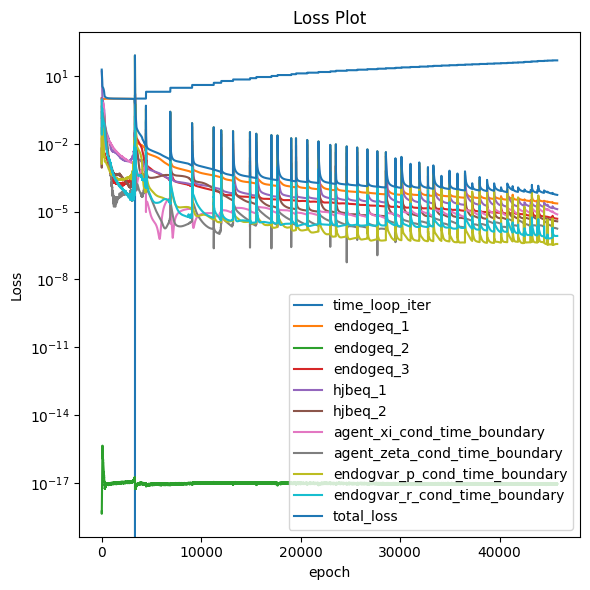

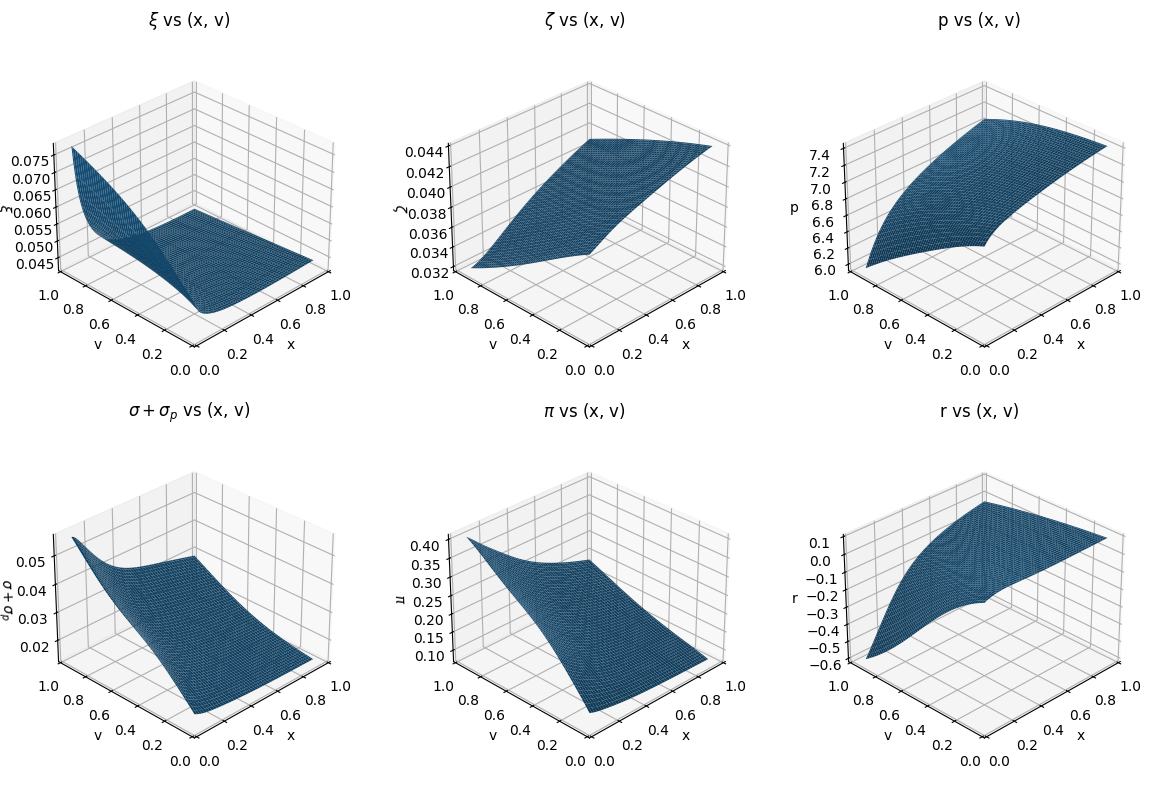

In [4]:
plot_loss_df(fn="./models/ditella/model_min_loss.csv", loss_plot_fn="./models/ditella/model_min_loss.png")
pde_model.plot_vars([r"$\xi$", r"$\zeta$", "p", 
                     r"$\sigma+\sigma_p = \sigma + \sigma_p$", r"$\pi$", "r"], ncols=3)

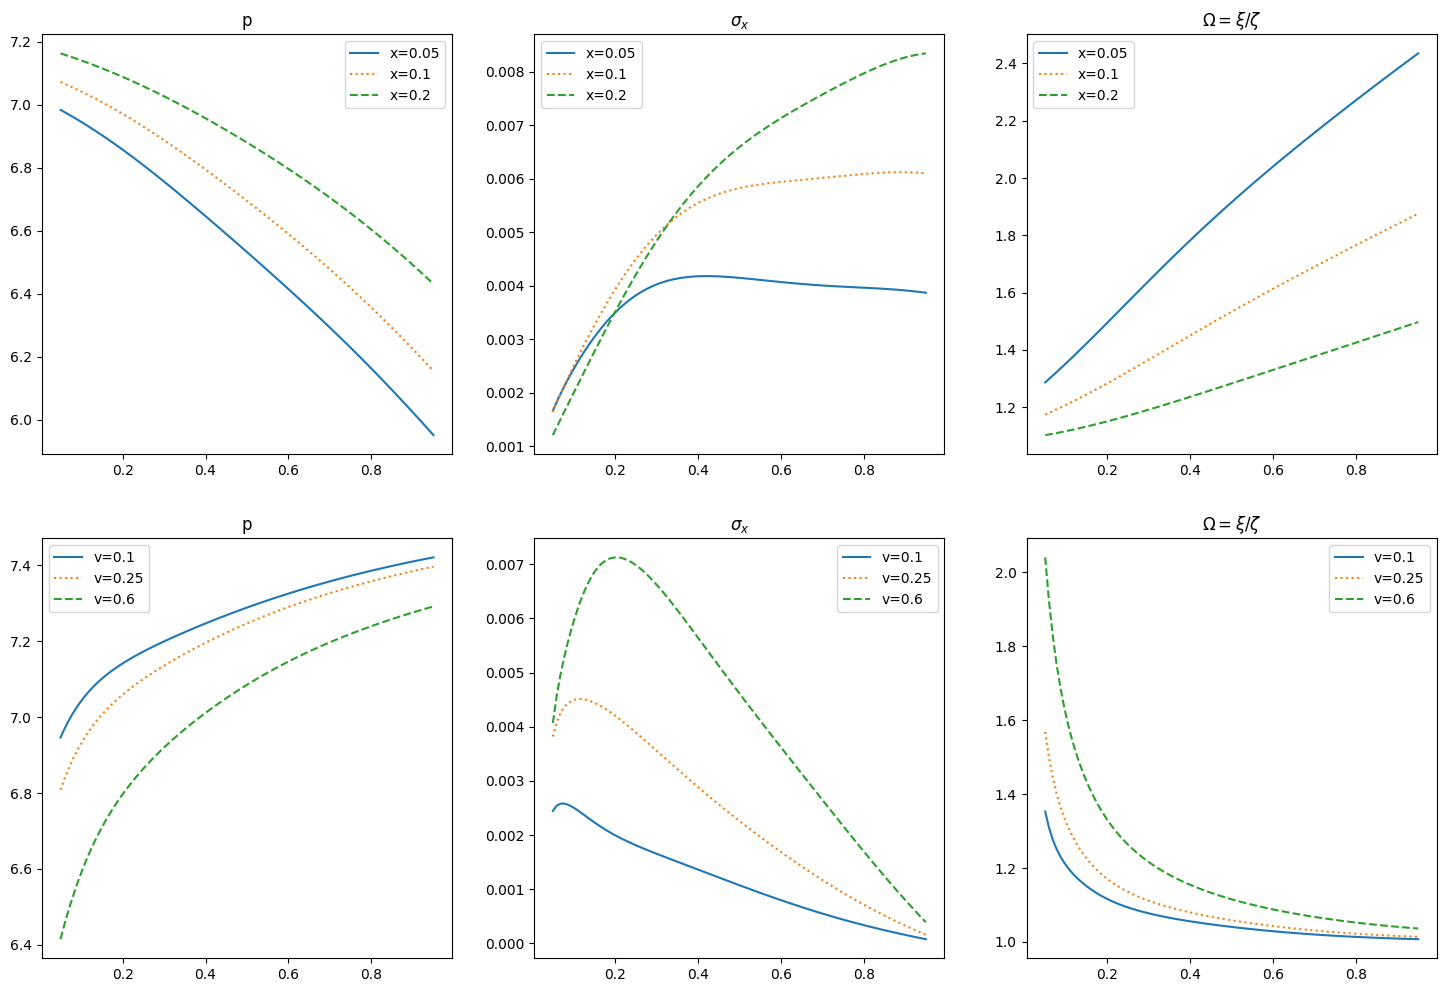

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"p")
    ax[0][1].set_title(r"$\sigma_x$")
    ax[0][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()

for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"p")
    ax[1][1].set_title(r"$\sigma_x$")
    ax[1][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()

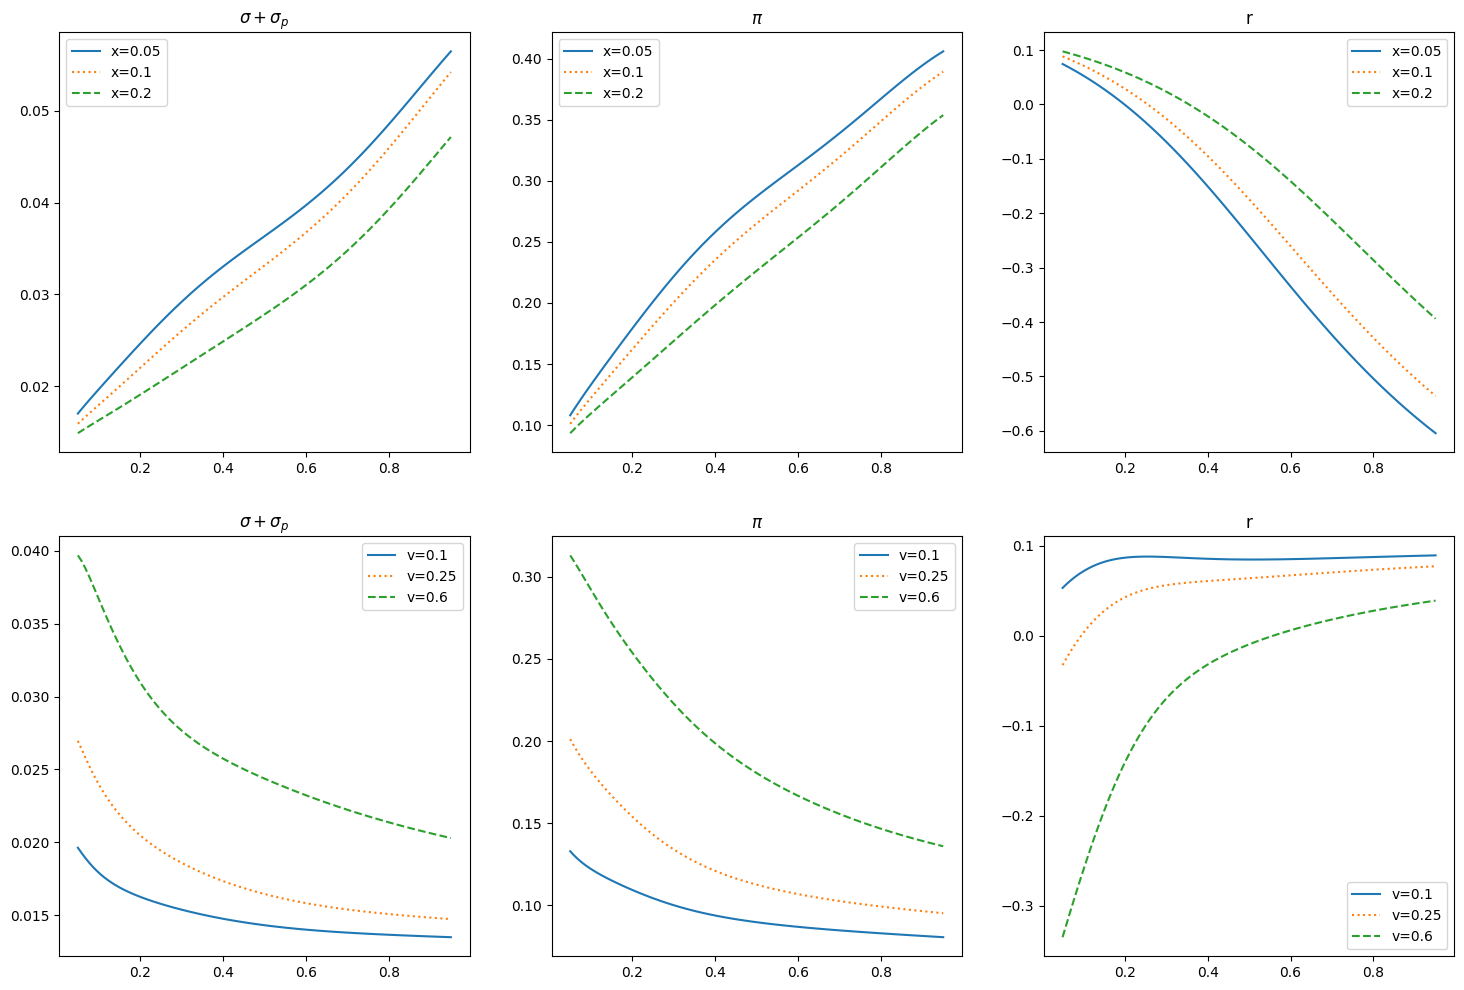

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"$\sigma+\sigma_p$")
    ax[0][1].set_title(r"$\pi$")
    ax[0][2].set_title("r")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()
for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"$\sigma+\sigma_p$")
    ax[1][1].set_title(r"$\pi$")
    ax[1][2].set_title("r")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()